<a href="https://colab.research.google.com/github/lg550055/style-classify/blob/main/StyleClassify10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebok contains three modules:

#### 1.   **Scraper** - Upon a text prompt, returns a url to the desired image from the web using google search
#### 2.   **Styler** - Pretrained model to add the desired style to any image
#### 3.   **Classifier** - Deep leaning model to classify an image (within the model's categories)

#### *These modules work standalone or together.  For example, the output of the Scraper can be passed as the content image to the Styler and / or to the Classifier.*

---


In [ ]:
# @title Common imports
import functools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

---

## **Scraper**
### Upon a text prompt, retrieves a url for the desired type of image

In [ ]:
# @title google search module install
!pip install google-search-results

In [2]:
from serpapi import GoogleSearch

def get_google_images():
    """ Returns the first image url in a dictionary storing search results """

    search_query = input("What can I find for you?")
    params = {
      "api_key": "6a4bd7e2a839c31c2082c98bf00cbd8d341769a99caf82e75a2bb96d67e54b4c",
      "engine": "google",
      "q": f"{search_query}",
      "tbm": "isch"
    }
    search = GoogleSearch(params)
    results = search.get_dict()
    return results['images_results'][0]['original']
 
get_google_images()

What can I find for you?empire state building
https://serpapi.com/search


'https://upload.wikimedia.org/wikipedia/commons/c/c7/Empire_State_Building_from_the_Top_of_the_Rock.jpg'

---

## **Styler**
###Given an image and a style image, returns a styled image

##### Based on the model code in [magenta](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization)

##### Uses a pretrained model [Fast arbitrary image style transfer](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2)

In [ ]:
# @title Resize, load and plot image functions

def crop_center(image):
  """ Returns a cropped square image """
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """ Loads, caches and preprocesses images """
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]
  img = tf.io.decode_image(tf.io.read_file(image_path), channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def plot_images(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  plt.figure(figsize=(18, 9))
  for i in range(n):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

### The block below undertakes the following steps:
#### 1. Allows you to select content and style image
#### 2. Pre-processes each image
#### 3. Shows the pre-processed images side-by-side

3186688/3170828 [==============================] - 0s 0us/step


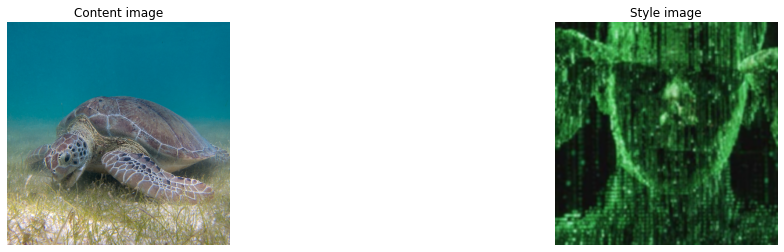

In [ ]:
# @title Select a sample image and a style image (*follow docstring to use an image from the web*)

sample_images = {
    'sea_turtle' : 'https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
    'golden_gate' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg',
    'dog' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Dog_%28Canis_lupus_familiaris%29_%285%29.JPG/640px-Dog_%28Canis_lupus_familiaris%29_%285%29.JPG'
    }

styles = { 'picasso_demoiselles_avignon': 'https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
          'picasso_violin': 'https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
          'picasso_bottle_of_rum': 'https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
          'kanagawa_great_wave': 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
          'van_gogh_starry_night': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
          'miro': 'https://upload.wikimedia.org/wikipedia/commons/1/1f/Joan_Mir%C3%B3%2C_1978_-_Gaud%C3%AD_36.jpg',
          'matrix': 'https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fb7081878-f5a2-4494-be73-cca8219811fd_636x367.png'
          }

image = 'dog' # @param ['dog','sea_turtle','golden_gate']
content_image_url = sample_images[image]

""" To get an image from the web, uncomment the line below and comment the line above """
# content_image_url = get_google_images()

my_style = 'matrix' # @param ['matrix','miro','van_gogh_starry_night','kanagawa_great_wave','picasso_violin']
style_image_url = styles[my_style]

# The content image size can be arbitrary.
content_img_size = (384, 384)

# The style model was trained with image size 256 (recommended for the style image;
# other sizes work but will lead to different results).
style_img_size = (256, 256)

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
plot_images([content_image, style_image], ['Content image', 'Style image'])

### The following block undertakes these steps:
#### 1. Imports pre-trained model (from TF Hub)
#### 2. Uses the model to apply the selected style to the content image
#### 3. Shows the results side-by-side

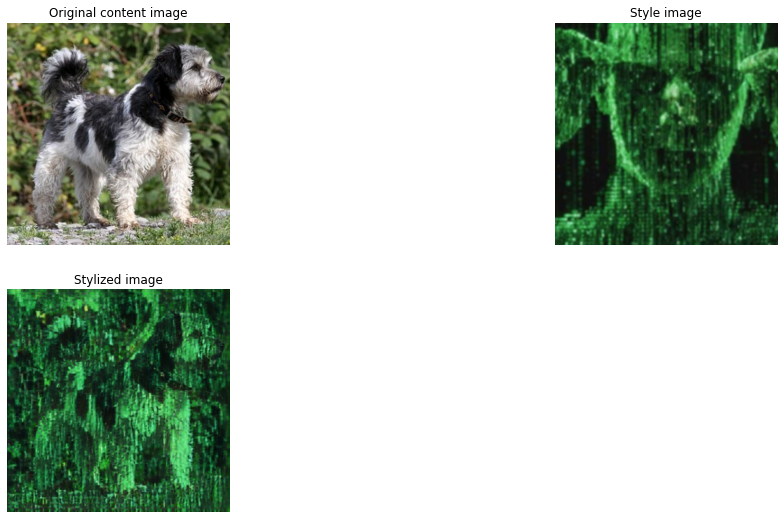

In [ ]:
# Load TF Hub module -transfer learning

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# content_image, style_image, and stylized_image are 4D Tensors shape [batch_size, image_height, image_width, 3]
# Style content image with the style image (takes a few millisecondson on a GPU)
output = hub_module(content_image, style_image)
stylized_image = output[0]

plot_images([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

---

## **Image classifier**
### Classifies an image into one of 10 categories
#### Deep learning model trained on the cifar10 dataset

In [ ]:
# @title Imports and splits the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 2s 0us/step


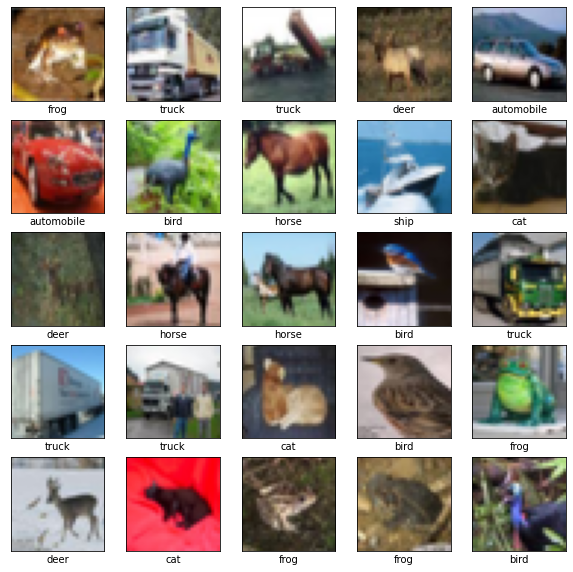

In [ ]:
# @title Plots a sample of training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    # The CIFAR labels are arrays, thus the need for the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
# @title Builds the deep learning model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# @title Compiles, trains and evaluates the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

Epoch 1/10
1563/1563 [==============================] - 8s 4ms/step - loss: 1.5353 - accuracy: 0.4392
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1682 - accuracy: 0.5872
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0229 - accuracy: 0.6393
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9311 - accuracy: 0.6726
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8641 - accuracy: 0.6966
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8064 - accuracy: 0.7166
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7562 - accuracy: 0.7339
Epoch 8/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7175 - accuracy: 0.7472
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6772 - accuracy: 0.7600
Epoch 10/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.64

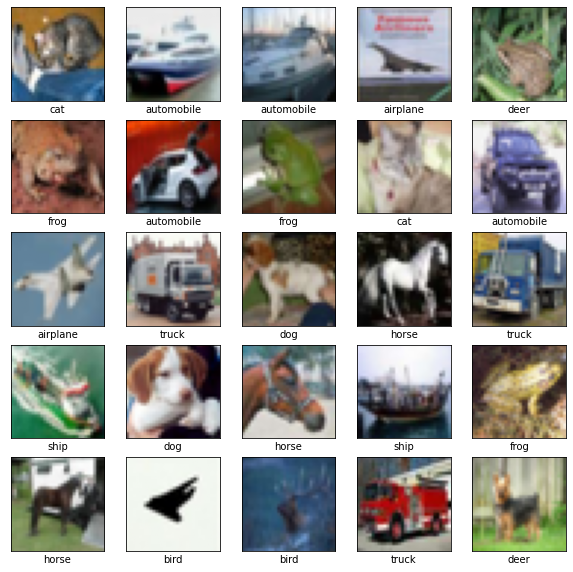

In [ ]:
# @title Makes predictions and visualizes a sample of them
predictions = model.predict(test_images)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i])
    plt.xlabel(class_names[np.argmax(predictions[i])])
plt.show()

In [ ]:
# @title Use 1 sample to confirm the predicted label matches the actual label (show the corresponding label name)

# np.argmax returns the index of the max element
predicted_label = np.argmax(predictions[0])
actual_label = test_labels[0][0]
# see if the prediction's highest probability label matches the actual label
print (predicted_label)
print (actual_label)
class_names[predicted_label]

3
3


'cat'

---

### Use the **Classifier** to predict the class of the content image used in the **Styler**

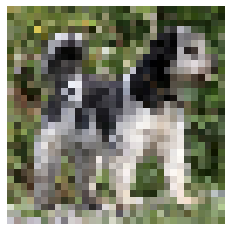

In [ ]:
# @title Resize image to match expected model shape
resized = tf.image.resize(content_image[0], [32,32])

plt.imshow(resized)
plt.axis('off')
plt.show()

In [ ]:
# @title Make and display the prediction

# add the expected batch dimension to the resized image
r = tf.expand_dims(resized, axis=0)

prediction = model.predict(r)
class_names[np.argmax(prediction[0])]

'dog'

---

### End of notebook

---
